In [0]:
from fastai.vision import *
from fastai.callbacks import *
from fastai.metrics import error_rate
import pandas as pd
import torch.nn as nn
import cv2
import concurrent
from tqdm import tqdm

In [0]:
from google.colab import drive, files, auth
drive.mount("/content/drive")

In [0]:
base = Path('/content/drive/My Drive/images')
train = base/'train/'
occ = base/'people_crops/'
test = base/'test/'

# Hotel Recognition
### Brennan Gebotys, Chloe Wang, Nasir Safdari
### May 10th 2019 - Week 1 Milestone

---

## Introduction
Recognizing a hotel from an image of a hotel room is important for human trafficking investigations. Whether used for advertising or exchanged among criminal networks, these photographs can serve as visual evidence of where the victim was trafficked. However, it is not an easy task for the investigators to pinpoint which hotel it is, due to the two inherent challenges to this task:

1.   The presence of common objects in all hotel rooms (i.e. desk, beds etc.)

2.   Poor quality of images (i.e. images often taken in absurd angles, under poor lighting, and occluded by figures of the victim)

The advancements in artificial neural network and deep learning have pushed the frontiers in both object and scene recognition tasks, which are relevant to the hotel recognition.

*   hotel chain recognition: *Fixed-object*
i.e. the same hotel chain would have similar decorations in all their rooms (e.g. shape of desks, color of bed headboards)

*   hotel instance recognition: *Fixed-scene*
i.e. different hotel rooms from the same chain may see different placements of objects, more of an image retrieval task

Here, we focus on hotel chain recognition from low-quality, occluded images similar to the ones used in human trafficking.


## Methodology
*   Dataset creation

To mimic the images used for human trafficking, we took a subset of images from Hotels-50K dataset Traffick-Cam category (i.e. lower-quality hotel images taken by travellers) and applied data augmentations including human figure occlusion (Stylianou et al., 2019). In the current stage, for the train set, we included 5 most occurred hotel chains with 1000 images for each class.

* Applying Occlusions to Training Images

To ensure our training examples are similar to the test set, we apply occlusions to our images using a custom fast.ai transformation. We choose a random occlusion to apply and then stretch, and place it randomly. When applying occlusions we also ensure it does not occlude more than 80% of the training image.

*  Model training

Resnets are known to be good for fixed-object tasks, which is very relevant to our problem. Therefore, we decided to employ the pretrained Resnet34 in fast.ai library. The best learning rate was found through lr_find, with the other pre-training parameters by library default.

* Next steps

Some next steps we may take include:

1.   Increase the number of training classes (i.e. hotel chains) and images per class
2.   Experiment with alternate neural network architecture, freezing epochs etc.
3.   Test different forms of regularization



# Data Analysis

## View Training Examples

In [0]:
# load data frames for training
data_df = pd.read_csv(base/'5kpaths.csv')
occ_df = pd.read_csv(base/'occlusions.csv')

In [0]:
data_df.head()

,chain_id,hotel_id,d_source,image_id,path
0,3,18187,traffickcam,3485,/content/drive/My Drive/images/train/3/18187/t...
1,3,18187,traffickcam,2599229,/content/drive/My Drive/images/train/3/18187/t...
2,3,18187,traffickcam,2599232,/content/drive/My Drive/images/train/3/18187/t...
3,3,18187,traffickcam,2612971,/content/drive/My Drive/images/train/3/18187/t...
4,3,18187,traffickcam,2632017,/content/drive/My Drive/images/train/3/18187/t...


In [0]:
batch_size = 32
img_size = 224

ds_tfms = get_transforms(max_rotate=35, max_zoom=1.4, max_lighting=0.2,
                         max_warp=0.4, p_affine=1.0, p_lighting=1.0)
label_col = 0 # predict the chain_id
fn_col = -1

In [0]:
# View batch of training Images
data = ImageDataBunch.from_df('/', 
                              data_df, 
                              label_col=label_col,
                              fn_col=fn_col, 
                              ds_tfms=ds_tfms, 
                              size=img_size,
                              bs=batch_size)

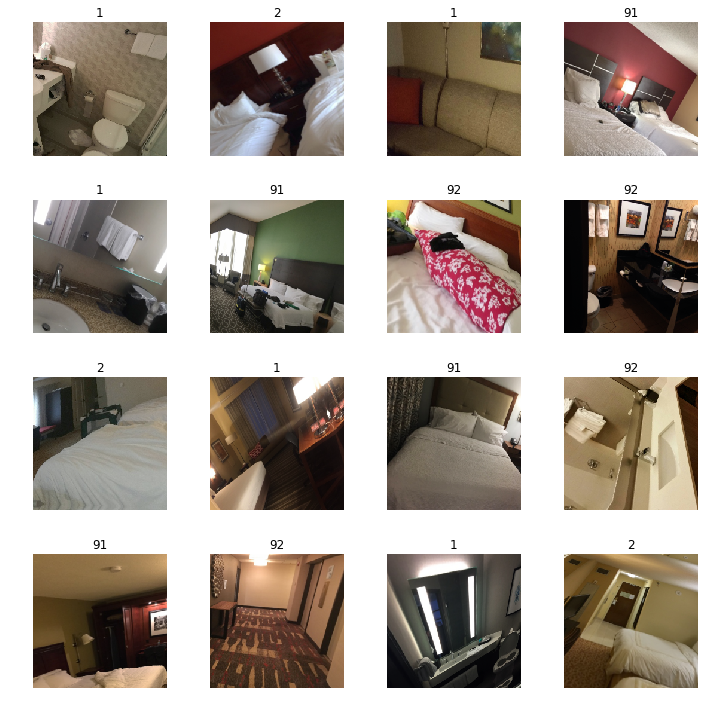

In [0]:
data.show_batch(rows=4, figsize=(10, 10))

# Occlusion 
Since the testing set contains occlusions and the training set does not we decided to apply the occlusions using a fast.ai data transformation.

We apply the occlusion to training examples using the following steps:
- select an occlusion from the data frame at random
- resize the occlusion by stretching the image randomly in both the x and y direction
- repeat the previous step until the size of the occlusion is less than `max_fill_percent` of the image
- decide the location of the occlusion at random
- apply an element-wise multiplication with the occlusion as a binary-mask to the image



## View Occlusions

In [0]:
occ_df.head()

,occlusion_id,path
0,4029.png,/content/drive/My Drive/images/people_crops/40...
1,3746.png,/content/drive/My Drive/images/people_crops/37...
2,3020.png,/content/drive/My Drive/images/people_crops/30...
3,3034.png,/content/drive/My Drive/images/people_crops/30...
4,28494.png,/content/drive/My Drive/images/people_crops/28...


In [0]:
# View batch of training Images
occ_data = ImageDataBunch.from_df('/', 
                              occ_df[:100], 
                              label_col=0,
                              fn_col=-1, 
                              size=224,
                              bs=batch_size)

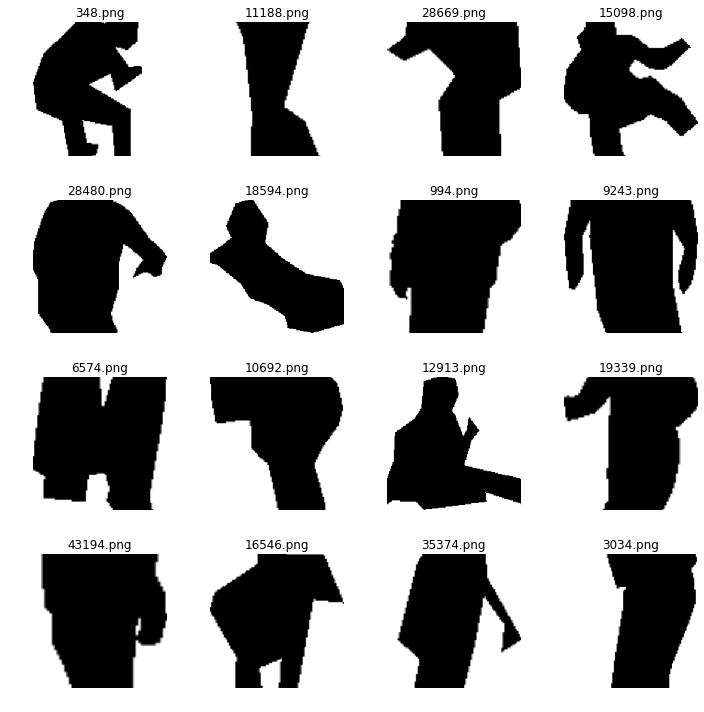

In [0]:
occ_data.show_batch(rows=4, figsize=(10, 10))

## Applying Occlusions

In [0]:
def apply_occlusion(img, occlusion_idx=None, scale_resize=1., max_fill_percent=0.8):
    img_c, img_h, img_w = img.shape
    
    # load occlusion
    occ_idx = np.random.randint(len(occ_df)) if not occlusion_idx else occlusion_idx
    occ_path = occ_df.loc[occ_idx].path 
    occ = cv2.imread(occ_path)
    if occ is None: return img 

    # random resize taking up < `max_fill_percent`% of image 
    while True:
        resized_occ = cv2.resize(occ, (0, 0),
                               fx=max(np.random.uniform(low=0.1, high=0.7) * scale_resize, 0.4), 
                               fy=max(np.random.uniform(low=0.1, high=0.7) * scale_resize, 0.4))
        percent_filled = np.sum(resized_occ[:, :, 0] // 255) / (img_h * img_w)
        h, w, _ = resized_occ.shape
    
        if percent_filled < max_fill_percent and h < img_h and w < img_w: 
            occ_mask = (1 - resized_occ // 255)
            break
    
    
    occ_h, occ_w, _ = occ_mask.shape
    d_height = img_h - occ_h 
    d_width = img_w - occ_w
    
    # random placement 
    p_top = np.random.uniform() 
    p_left = np.random.uniform() 
    top_fill = int(d_height * p_top)
    bottom_fill = d_height - top_fill
    left_fill = int(d_width * p_left)
    right_fill = d_width - left_fill
    
    fit_occ_mask = cv2.copyMakeBorder(occ_mask, top_fill, bottom_fill, left_fill, right_fill, cv2.BORDER_CONSTANT)
    tensor_occ_mask = torch.from_numpy(1 - fit_occ_mask[:, :, 0]).type(torch.float)

    return tensor_occ_mask * img    

In [0]:
# apply occlusions to training images
def get_occlusion_trans(max_fill_percent=0.8):
  def _occlusion(x):
      x = apply_occlusion(x, max_fill_percent=max_fill_percent)
      return x
  return TfmPixel(_occlusion)

In [0]:
# add occlusions to the transformation
occ = get_occlusion_trans(max_fill_percent=0.8)
ds_tfms = get_transforms(max_rotate=35, max_zoom=1.4, max_lighting=0.2,
                         max_warp=0.4, p_affine=1.0, p_lighting=1.0,
                         xtra_tfms=[occ()])

In [0]:
# new databunch with occlusions
data = ImageDataBunch.from_df('/', 
                            data_df, 
                            label_col=label_col,
                            fn_col=fn_col, 
                            ds_tfms=ds_tfms, 
                            size=img_size,
                            bs=batch_size)

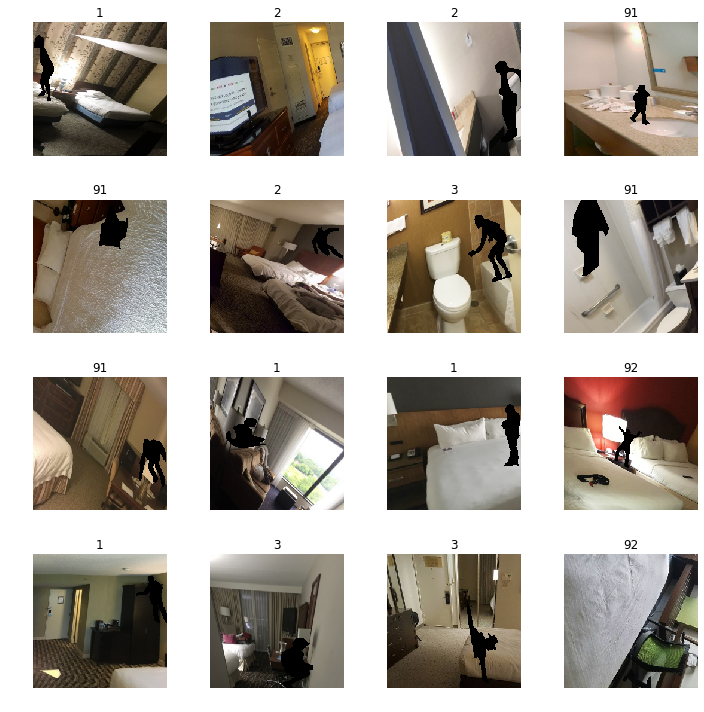

In [0]:
data.show_batch(rows=4, figsize=(10, 10))

# Training - resnet18

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


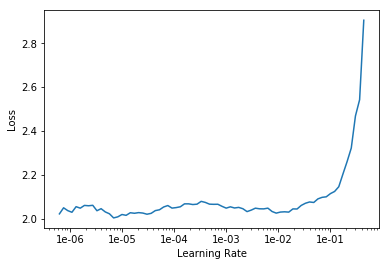

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-2

In [0]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.794856,1.620189,0.674000,08:34
1,1.584558,1.377349,0.598000,02:28
2,1.425352,1.336769,0.582000,02:27


In [0]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.458279,1.370972,0.592000,02:25
1,1.432255,1.307924,0.557000,02:18
2,1.345639,1.234916,0.500000,02:17


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/100, lr)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.291452,1.146146,0.467000,02:17
1,1.240833,1.128007,0.464000,02:17
2,1.223055,1.140463,0.451000,02:17
3,1.182215,1.128924,0.441000,02:16
4,1.194225,1.253106,0.504000,02:12


KeyboardInterrupt: ignored

In [0]:
learn.save('stage-2-resnet18');

# Training - resnet101

In [0]:
learn = cnn_learner(data, models.resnet101, metrics=error_rate)

In [0]:
lr=5e-3

In [0]:
learn.fit_one_cycle(6, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.837513,1.571812,0.610000,05:24
1,1.504022,1.370168,0.564000,02:58
2,1.355167,1.245548,0.511000,03:01
3,1.264135,1.119847,0.452000,03:02
4,1.172259,1.041964,0.410000,03:03
5,1.101065,1.033792,0.419000,03:04


In [0]:
learn.save('stage-1-resnet101')

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/100, lr)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.5, callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best-stage2-resnet101')])

epoch,train_loss,valid_loss,error_rate,time
0,1.082129,0.969149,0.378000,03:14
1,1.093973,1.060098,0.414000,03:12


/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:50: UserWarning: <class 'fastai.callbacks.tracker.SaveModelCallback'> conditioned on metric `accuracy` which is not available. Available metrics are: train_loss, valid_loss, error_rate, time
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')


KeyboardInterrupt: ignored

# Results

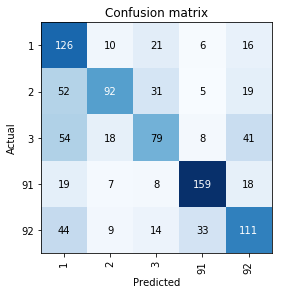

In [0]:
interp1 = ClassificationInterpretation.from_learner(learn)
interp1.plot_confusion_matrix()

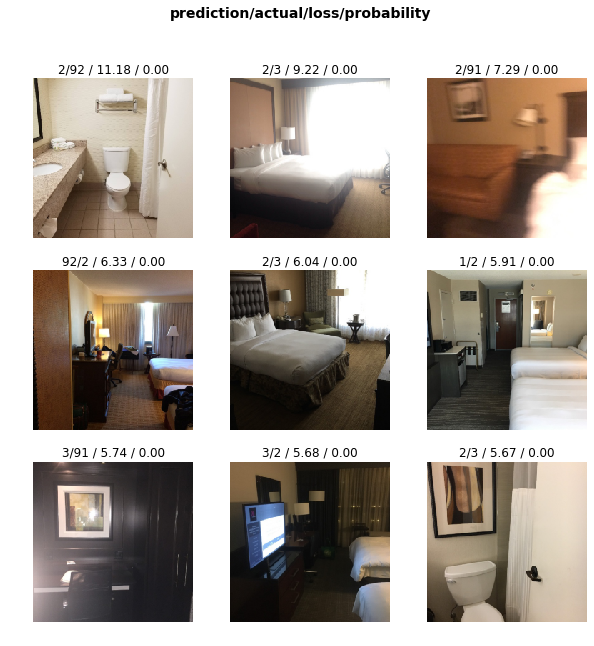

In [0]:
interp1.plot_top_losses(9, figsize=(10, 10), heatmap=False)